In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

## NYUDv2 Dataset

In [2]:
# !wget https://hydranets-data.s3.eu-west-3.amazonaws.com/hydranets-data-2.zip && unzip -q hydranets-data-2.zip && mv hydranets-data-2/* . && rm hydranets-data-2.zip && rm -rf hydranets-data-2

In [3]:
import glob

depth = sorted(glob.glob("nyud/depth/*.png"))
seg = sorted(glob.glob("nyud/masks/*.png"))
images = sorted(glob.glob("nyud/rgb/*.png"))
print(len(images), len(seg), len(depth))

1449 1449 1449


In [4]:
CMAP = np.load('cmap_nyud.npy')
print(len(CMAP))

256


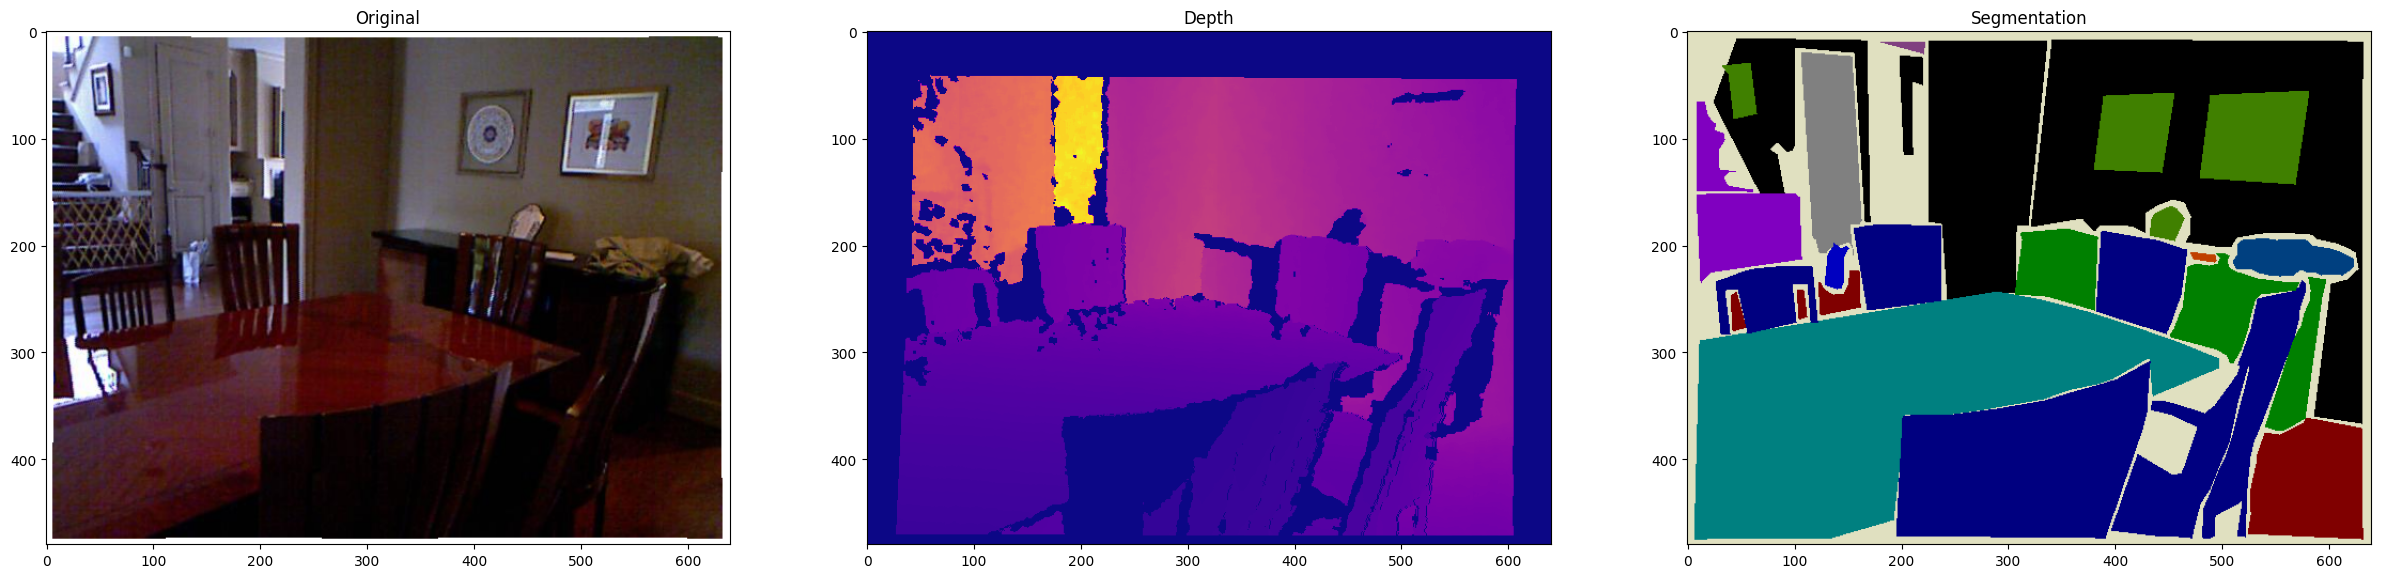

In [5]:
idx = np.random.randint(0,len(seg))

f, (ax0, ax1, ax2) = plt.subplots(1,3, figsize=(30,90))
ax0.imshow(np.array(Image.open(images[idx])))
ax0.set_title("Original")
ax1.imshow(np.array(Image.open(depth[idx])), cmap="plasma")
ax1.set_title("Depth")
ax2.imshow(CMAP[np.array(Image.open(seg[idx]))])
ax2.set_title("Segmentation")
plt.show()

In [6]:
print(np.unique(np.array(Image.open(seg[idx]))))
print(len(np.unique(np.array(Image.open(seg[idx])))))

[  0   1   2   4   6   7  10  20  21  25  36  37 255]
13


In [7]:
data_file = "train_list_depth.txt"
with open(data_file, "rb") as f:
    datalist = f.readlines()
datalist = [x.decode("utf-8").strip("\n").split("\t") for x in datalist]
root_dir = "/nyud"
masks_names = ("segm", "depth")

print(datalist[0])

['rgb/000003.png', 'masks/000003.png', 'depth/000003.png']


In [8]:
import os
abs_paths = [os.path.join("nyud", rpath) for rpath in datalist[0]]
abs_paths

['nyud\\rgb/000003.png', 'nyud\\masks/000003.png', 'nyud\\depth/000003.png']

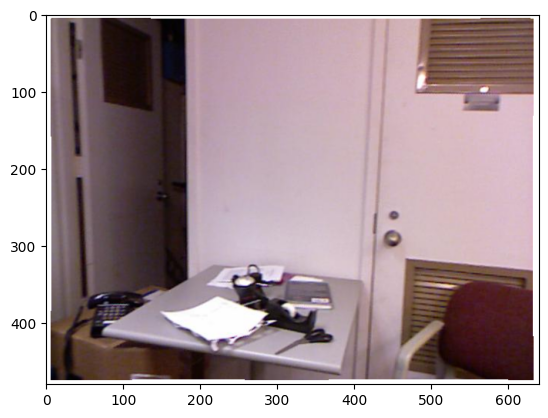

In [9]:
img_arr = np.array(Image.open(abs_paths[0]))

plt.imshow(img_arr)
plt.show()

segm
nyud\masks/000003.png


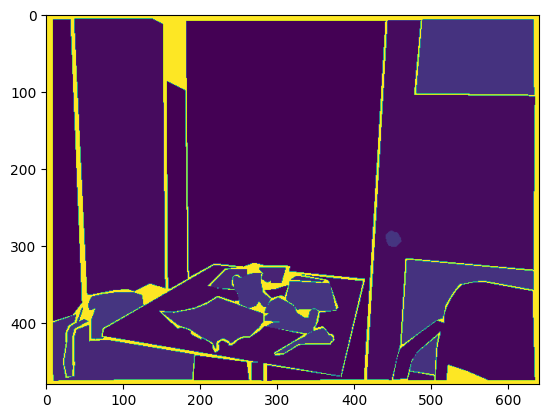

depth
nyud\depth/000003.png


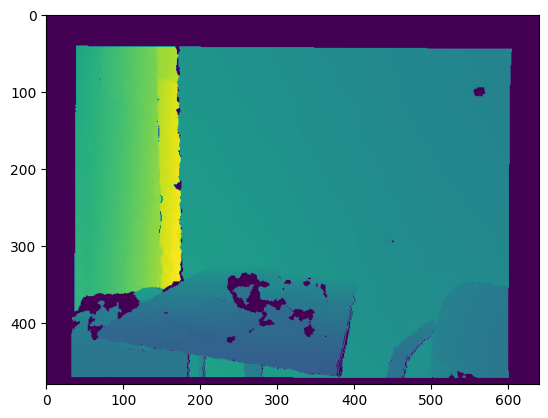

In [10]:
masks_names = ("segm", "depth")

for mask_name, mask_path in zip(masks_names, abs_paths[1:]):
    print(mask_name)
    print(mask_path)
    mask = np.array(Image.open(mask_path))
    plt.imshow(mask)
    plt.show()

In [11]:
from utils import Normalise, RandomCrop, ToTensor, RandomMirror
import torchvision.transforms as transforms

In [12]:
img_scale = 1.0 / 255
depth_scale = 5000.0

img_mean = np.array([0.485, 0.456, 0.406])
img_std = np.array([0.229, 0.224, 0.225])

normalise_params = [img_scale, img_mean.reshape((1, 1, 3)), img_std.reshape((1, 1, 3)), depth_scale,]

transform_common = [Normalise(*normalise_params), ToTensor()]

In [13]:
crop_size = 400
transform_train = transforms.Compose([RandomMirror(), RandomCrop(crop_size)] + transform_common)
transform_val = transforms.Compose(transform_common)

In [14]:
train_batch_size = 8
val_batch_size = 4
train_file = "train_list_depth.txt"
val_file = "val_list_depth.txt"

In [15]:
from Dataset import NYUDv2Dataset
from torch.utils.data import DataLoader

#TRAIN DATALOADER
train_loader = DataLoader(
    NYUDv2Dataset(train_file, transform=transform_train,),
    batch_size=train_batch_size,
    shuffle=True,
    num_workers=0,
    pin_memory=True,
    drop_last=True,
)

# VALIDATION DATALOADER
val_loader = DataLoader(
    NYUDv2Dataset(val_file, transform=transform_val,),
    batch_size=val_batch_size,
    shuffle=False, num_workers=4,
    pin_memory=True,
    drop_last=False,
)

In [16]:
from MobileNetV2 import MobileNetv2

encoder = MobileNetv2()
encoder.load_state_dict(torch.load("mobilenetv2-e6e8dd43.pth"))

<All keys matched successfully>

In [17]:
from LightweightRefineNet import LightWeightRefineNet

num_classes = (40, 1)
decoder = LightWeightRefineNet(encoder._out_c, num_classes)

## Training the Model

In [18]:
from utils import InvHuberLoss

ignore_index = 255
ignore_depth = 0

crit_segm = nn.CrossEntropyLoss(ignore_index=ignore_index).cuda()
crit_depth = InvHuberLoss(ignore_index=ignore_depth).cuda()

In [19]:
lr_encoder = 1e-2
lr_decoder = 1e-3
momentum_encoder = 0.9
momentum_decoder = 0.9
weight_decay_encoder = 1e-5
weight_decay_decoder = 1e-5

In [20]:
n_epochs = 1000

In [21]:
from model_helpers import Saver, load_state_dict
import operator
import json
import logging

init_vals = (0.0, 10000.0)
comp_fns = [operator.gt, operator.lt]
ckpt_dir = "./"
ckpt_path = "./checkpoint.pth.tar"

saver = Saver(
    args=locals(),
    ckpt_dir=ckpt_dir,
    best_val=init_vals,
    condition=comp_fns,
    save_several_mode=all,
)

In [22]:
optims = [torch.optim.SGD(encoder.parameters(), lr=lr_encoder,
                          momentum=momentum_encoder, weight_decay=weight_decay_encoder),
         torch.optim.SGD(decoder.parameters(), lr=lr_decoder,
                         momentum=momentum_decoder, weight_decay=weight_decay_decoder)
          ]

In [23]:
hydranet = nn.DataParallel(nn.Sequential(encoder, decoder).cuda()) # Use .cpu() if you prefer a slow death

print("Model has {} parameters".format(sum([p.numel() for p in hydranet.parameters()])))

start_epoch, _, state_dict = saver.maybe_load(ckpt_path=ckpt_path, keys_to_load=["epoch", "best_val", "state_dict"],)
load_state_dict(hydranet, state_dict)

if start_epoch is None:
    start_epoch = 0

Model has 3070057 parameters


In [24]:
opt_scheds = []
for opt in optims:
    opt_scheds.append(torch.optim.lr_scheduler.MultiStepLR(optimizer=opt,
                                                           milestones=np.arange(start_epoch + 1, n_epochs, 100),
                                                           gamma=0.1)
                      )

In [25]:
from utils import AverageMeter
from tqdm import tqdm

In [26]:
def train(model, opts, crits, dataloader, loss_coeffs=(1.0,), grad_norm=0.0):
    model.train()

    device = torch.device("cuda") if torch.cuda.is_available() else "cpu"
    loss_meter = AverageMeter()
    pbar = tqdm(dataloader)

    for sample in pbar:
        loss = 0.0
        input = sample["image"].float().to(device)
        targets = [sample[k].to(device) for k in dataloader.dataset.masks_names]
        #[[sample["depth"].to(device), sample["segm"].to(device)]
        #input, targets = get_input_and_targets(sample=sample, dataloader=dataloader, device=device) # Get the data
        outputs = model(input) # Forward
        #outputs = list(outputs)

        for out, target, crit, loss_coeff in zip(outputs, targets, crits, loss_coeffs):
            loss += loss_coeff * crit(
                F.interpolate(
                    out, size=target.size()[1:], mode="bilinear", align_corners=False
                ).squeeze(dim=1),
                target.squeeze(dim=1),
            )

        # Backward
        for opt in opts:
            opt.zero_grad()
        loss.backward()
        if grad_norm > 0.0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), grad_norm)
        for opt in opts:
            opt.step()

        loss_meter.update(loss.item())
        pbar.set_description(
            "Loss {:.3f} | Avg. Loss {:.3f}".format(loss.item(), loss_meter.avg)
        )


In [27]:
def validate(model, metrics, dataloader):
    device = torch.device("cuda") if torch.cuda.is_available() else "cpu"
    model.eval()
    for metric in metrics:
        metric.reset()

    pbar = tqdm(dataloader)

    def get_val(metrics):
        results = [(m.name, m.val()) for m in metrics]
        names, vals = list(zip(*results))
        out = ["{} : {:4f}".format(name, val) for name, val in results]
        return vals, " | ".join(out)

    with torch.no_grad():
        for sample in pbar:
            # Get the Data
            input = sample["image"].float().to(device)
            targets = [sample[k].to(device) for k in dataloader.dataset.masks_names]

            #input, targets = get_input_and_targets(sample=sample, dataloader=dataloader, device=device)
            targets = [target.squeeze(dim=1).cpu().numpy() for target in targets]

            # Forward
            outputs = model(input)
            #outputs = make_list(outputs)

            # Backward
            for out, target, metric in zip(outputs, targets, metrics):
                metric.update(
                    F.interpolate(out, size=target.shape[1:], mode="bilinear", align_corners=False)
                    .squeeze(dim=1)
                    .cpu()
                    .numpy(),
                    target,
                )
            pbar.set_description(get_val(metrics)[1])
    vals, _ = get_val(metrics)
    print("----" * 5)
    return vals

In [28]:
from utils import MeanIoU, RMSE

In [29]:
crop_size = 400
batch_size = 4
val_batch_size = 4
val_every = 5
loss_coeffs = (0.5, 0.5)

for i in range(start_epoch, n_epochs):

    print("Epoch {:d}".format(i))
    train(hydranet, optims, [crit_segm, crit_depth], train_loader, loss_coeffs)

    for sched in opt_scheds:
        sched.step()

    if i % val_every == 0:
        metrics = [MeanIoU(num_classes[0]),RMSE(ignore_val=ignore_depth),]

        with torch.no_grad():
            vals = validate(hydranet, metrics, val_loader)
        saver.maybe_save(new_val=vals, dict_to_save={"state_dict": hydranet.state_dict(), "epoch": i})

Epoch 0


Loss 2.260 | Avg. Loss 3.529:  16%|█▌        | 16/99 [00:10<00:53,  1.56it/s]


KeyboardInterrupt: 